In [3]:
import numpy as np
import pandas as pd
import datetime
import glob
import math
import pickle as pkl
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import requests
import sys
from cpymad.madx import Madx


plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

def reset_mad_og():
    mad = Madx(stdout=False)
    mad.input('BEAM, PARTICLE=PROTON, PC = 2.794987;')
    mad.input('BRHO := BEAM->PC * 3.3356;')
    mad.call("./STANDARD_PR_YETS 2022-2023_20-MAR-2023.seq")
    mad.call("./ps_fb_lhc.str")
    mad.input('use, sequence = ps;')
    mad.input('seqedit,sequence = PS;flatten;endedit;')
    mad.input('use, sequence = ps;')
    return mad

def reset_mad(pos,s_pos,ssz):
    mad = Madx(stdout=False)
    mad.input('BEAM, PARTICLE=PROTON, PC = 2.794987;')
    mad.input('BRHO := BEAM->PC * 3.3356;')
    mad.call("./STANDARD_PR_YETS 2022-2023_20-MAR-2023.seq")
    mad.call("./ps_fb_lhc.str")
    mad.input('use, sequence = ps;')

    # mad.input('seqedit, sequence = PS;')
    # # mad.input('flatten;')
    # mad.input('select, flag=seqedit, class = MQNAAIAP;')
    # mad.input('select, flag=seqedit, class = MQNABIAP;')
    # mad.input('select, flag=seqedit, class = MQSAAIAP;')
    # mad.input('select, flag=seqedit, class = QNSD;')
    # mad.input('select, flag=seqedit, class = QNSF;')
    # # mad.input('makethin, sequence = PS;')
    # mad.input('remove, element=SELECTED;')
    # # mad.input('flatten;')
    # mad.input('endedit;')  

    mad.input('seqedit,sequence = PS;flatten;endedit;')
    mad.input('use, sequence = ps;')

    # mad.input('use, sequence = PS;')

    for i in s_pos:
        mad.input('MARK%02d: MARKER;' %(i+1))
    for i in pos:
        mad.input('MARK%02d_2: MARKER;' %(i+1))

    

    for i in s_pos:
        #print(i)
        mad.input('seqedit, sequence = PS;')
        mad.input('install, element= MARK%02d, at=' %(i+1) + str(ssz[i]-0.125)+', from=PS$START, last=true ;')
        mad.input('endedit;')
        mad.input('use, sequence=PS;')
        
    # for i in pos:
    #     mad.input('install, element= MARK%02d_2, at=' %(i+1) + str(ssz[i]+0.02)+', from=PS$START, last=true ;')

    
    mad.input('select, flag=makethin, CLASS=SBEND, THICK= false, SLICE =3;')
    mad.input('makethin, sequence=PS;')
    mad.twiss()
    mad.input('kd_SC = 0;')

    for s_idx in s_pos:
        if s_idx == 99: 
            mad.input('PR.QDN00_SC:  MULTIPOLE ,KNL:={0,kd_SC};')
        else: 
            mad.input('PR.QDN%02d_SC:  MULTIPOLE ,KNL:={0,kd_SC};' %(s_idx+1))

    # mad.input('kd1 = kd*0.12;')
    # mad.input('kf1 = kf*0.12;')
    # for s_idx in pos:
    #     if s_idx == 99: 
    #         mad.input('PR.QDN00:  MULTIPOLE ,KNL:={0,kd1};')
    #     elif (s_idx % 2) == 1: 
    #         mad.input('PR.QDN%02d:  MULTIPOLE ,KNL:={0,kd1};' %(s_idx+1))
    #     else:
    #         mad.input('PR.QFN%02d:  MULTIPOLE ,KNL:={0,kf1};' %(s_idx+1))

    mad.input('seqedit, sequence = PS;')

    for s_idx in s_pos:
        if s_idx == 99: 
            mad.input('replace, element=MARK100, by=PR.QDN00_SC;')
        else: 
            mad.input('replace, element=MARK%02d, by=PR.QDN%02d_SC;' %(s_idx+1,s_idx+1))


    # for s_idx in pos:
    #     if s_idx == 99: 
    #         mad.input('replace, element=MARK100, by=PR.QDN00;')
    #     elif (s_idx % 2) == 1: 
    #         mad.input('replace, element=MARK%02d_2, by=PR.QDN%02d;' %(s_idx+1,s_idx+1))
    #     else:
    #         mad.input('replace, element=MARK%02d_2, by=PR.QFN%02d;' %(s_idx+1,s_idx+1))
    
    
    
    mad.input('endedit;')
    mad.input('use, sequence=PS;')

    return mad

def match_tunes(madx,qx, qy):
    madx.input('''
        match, sequence=PS;
        vary, name= kd1, step= 0.00001;
        vary, name= kf1, step= 0.00001;
        global,sequence=PS,Q1= '''+str(6+qx)+''';
        global,sequence=PS,Q2= '''+str(6+qy)+''';
        jacobian, calls = 50000, tolerance=1.0e-15;
        endmatch;
        ''' )


def beta_to_emmitance(beam_width,beta,disp,dp):
    
    y_r = 3.147827939
    b_r = np.sqrt( 1. - (1./y_r**2) )
    width=beam_width
    emmitance = b_r*y_r*(width**2 - (disp*(10**3)*dp)**2)/ beta
    
    return emmitance



def add_wmarkers(madx,poss,ssz,s):
    for ee,i in enumerate(poss):
        print(i, 'install, element= MARK%02d, at=' %(i+1) + str(ssz[i]+s[ee])+', from=PS$START, last=true ;')
        madx.input('seqedit, sequence = PS;')
        madx.input('install, element= MARK%02d, at=' %(i+1) + str(ssz[i]+s[ee])+', from=PS$START, last=true ;')
        madx.input('endedit;')
        madx.input('use, sequence=PS;')
        

    for s_idx in poss:
        if s_idx == 99: 
            madx.input('PR.QDN00_SC:  MULTIPOLE ,KNL:={0,kd_SC};')
        else: 
            madx.input('PR.QDN%02d_SC:  MULTIPOLE ,KNL:={0,kd_SC};' %(s_idx+1))


    madx.input('seqedit, sequence = PS;')
    
    for s_idx in poss:
        if s_idx == 99: 
            madx.input('replace, element=MARK100, by=PR.QDN00_SC;')
        else: 
            madx.input('replace, element=MARK%02d, by=PR.QDN%02d_SC;' %(s_idx+1,s_idx+1))
    madx.input('endedit;')
    madx.input('use, sequence=PS;')
    
    return madx



In [4]:
from cl2pd import madx as cl2madx

f1 = cl2madx.tfs2pd('pfw_25.txt')
Table1=f1.iloc[0].TABLE
table1 = Table1.to_numpy()

idx_ssz = []
ssz = []
delta = [1.486343, 2.886343]
for i,elem in enumerate(table1[1:,0]):
    if elem.startswith('PS') and elem.endswith('START'):
        if (elem[3] == '1') or (elem[3] == '6'):
            ssz.append(table1[i,2] + delta[1])
            idx_ssz.append(i)
        else:
            ssz.append(table1[i,2] + delta[0])
            idx_ssz.append(i)
ssz = np.asarray(np.sort(ssz))


# ssz = []
# for i in range(100):                                                 #---- get the positions is 's' for all sections
#     j,_ = np.nonzero(table1 == 'PS%02d$END'%i)
#     ssz.append(float(table1[j,2] - 0.125))

ssz = np.asarray(np.sort(ssz))

s_operational = np.asarray([5,6,9,10,17,18,21,22,27,28,31,32,35,36,39,40,45,46,49,50,55,56,59,60,67,68,71,72,77,78,81,82,85,86,89,95,96,99,100])-1

s_possible = [i for i in np.arange(0,100,1)]
# g=2
# s_possible = np.asarray([[i,i+1] for i in range(g,100,4)]).reshape((50,))
# s_possible = np.where(s_possible==100,0,s_possible)

madx = reset_mad(s_operational,s_possible,ssz)
madx.twiss()
poss =np.array([6,18,22,23,28,29,32,40,42,46,47,51,56,57,72,91,92])
s = np.zeros(poss.shape)
# madx2 = add_wmarkers(madx,poss,ssz,s)
# madx2.twiss()


# print(madx2.table.summ.q1,madx2.table.summ.q2)
# print(madx2.eval('kd1;'))
# madx2.input('use, sequence=PS;')
# madx2.input('''
#         match, sequence=PS;
#         vary, name= kd1, step= 0.00001;
#         vary, name= kf1, step= 0.00001;
#         global,sequence=PS,Q1= '''+str(6.21362903)+''';
#         global,sequence=PS,Q2= '''+str(6.23846)+''';
#         jacobian, calls = 50000, tolerance=1.0e-15;
#         endmatch;
#         ''' )
# madx2.twiss()
# print(madx2.table.summ.q1,madx2.table.summ.q2)
# print(madx2.eval('kd1;'))

[6.22326128] [6.22394974]
[6.21362903] [6.23846]
Dx =  [-0.03769146]


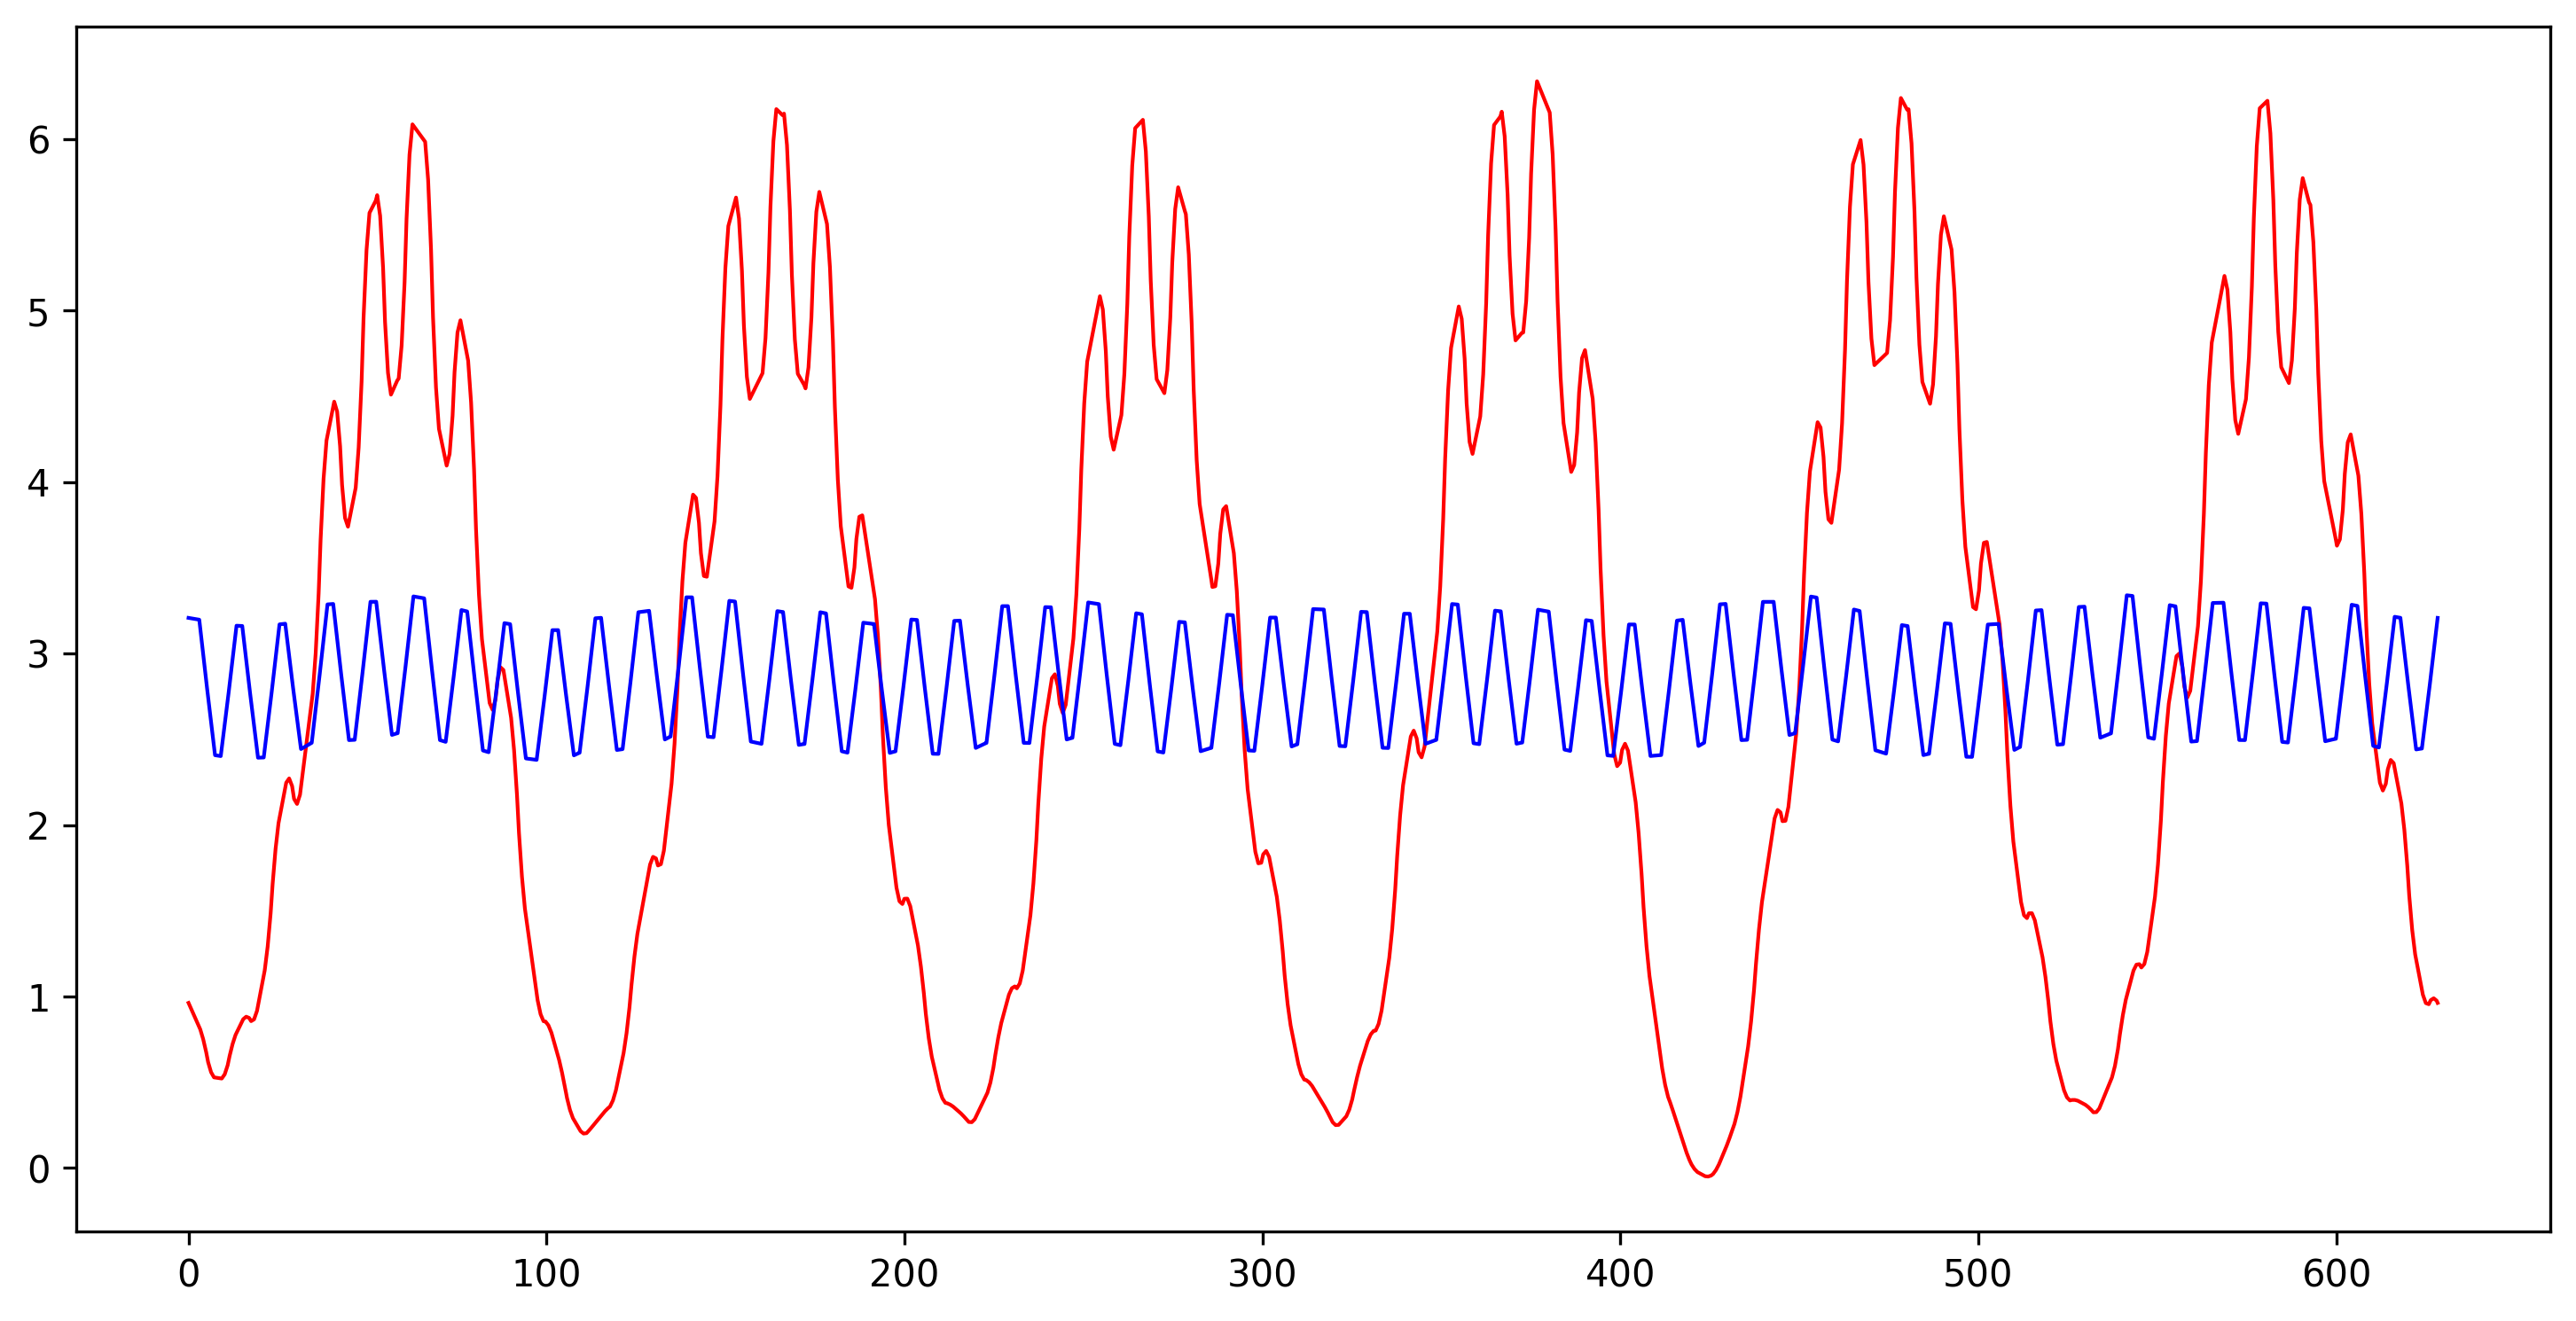

In [5]:
madx_og = reset_mad_og()

# madx_og.input('''
#         match, sequence=PS;
#             vary, name= kd, step= 0.00001;
#             vary, name= kf, step= 0.00001;
#             global,sequence=PS,Q1= '''+str(6.245)+''';
#             global,sequence=PS,Q2= '''+str(6.284)+''';
#             JACOBIAN, calls = 50000, tolerance=1.0e-15;
#         endmatch;
#         ''' )

# madx.input('''
#         match, sequence=PS;
#             vary, name= kd, step= 0.00001;
#             vary, name= kf, step= 0.00001;
#             global,sequence=PS,Q1= '''+str(6.245)+''';
#             global,sequence=PS,Q2= '''+str(6.284)+''';
#             JACOBIAN, calls = 50000, tolerance=1.0e-15;
#         endmatch;
#         ''' )
madx.input('Dx_bwsh68_leq = 1.0;')
madx.input("twiss, file=twiss_ps;")
madx.twiss()
plt.plot(madx.table.twiss.s,madx.table.twiss.dx, 'r-')

madx_og.twiss()
plt.plot(madx_og.table.twiss.s,madx_og.table.twiss.dx, 'b-')

print(madx.table.summ.q1,madx.table.summ.q2)
print(madx_og.table.summ.q1,madx_og.table.summ.q2)


idxH =[idx for idx,name in enumerate(madx.table.twiss['name']) if name.startswith('pr.bwsh68')]
print('Dx = ', madx.table.twiss['Dx'][idxH])

-0.000759001419124517

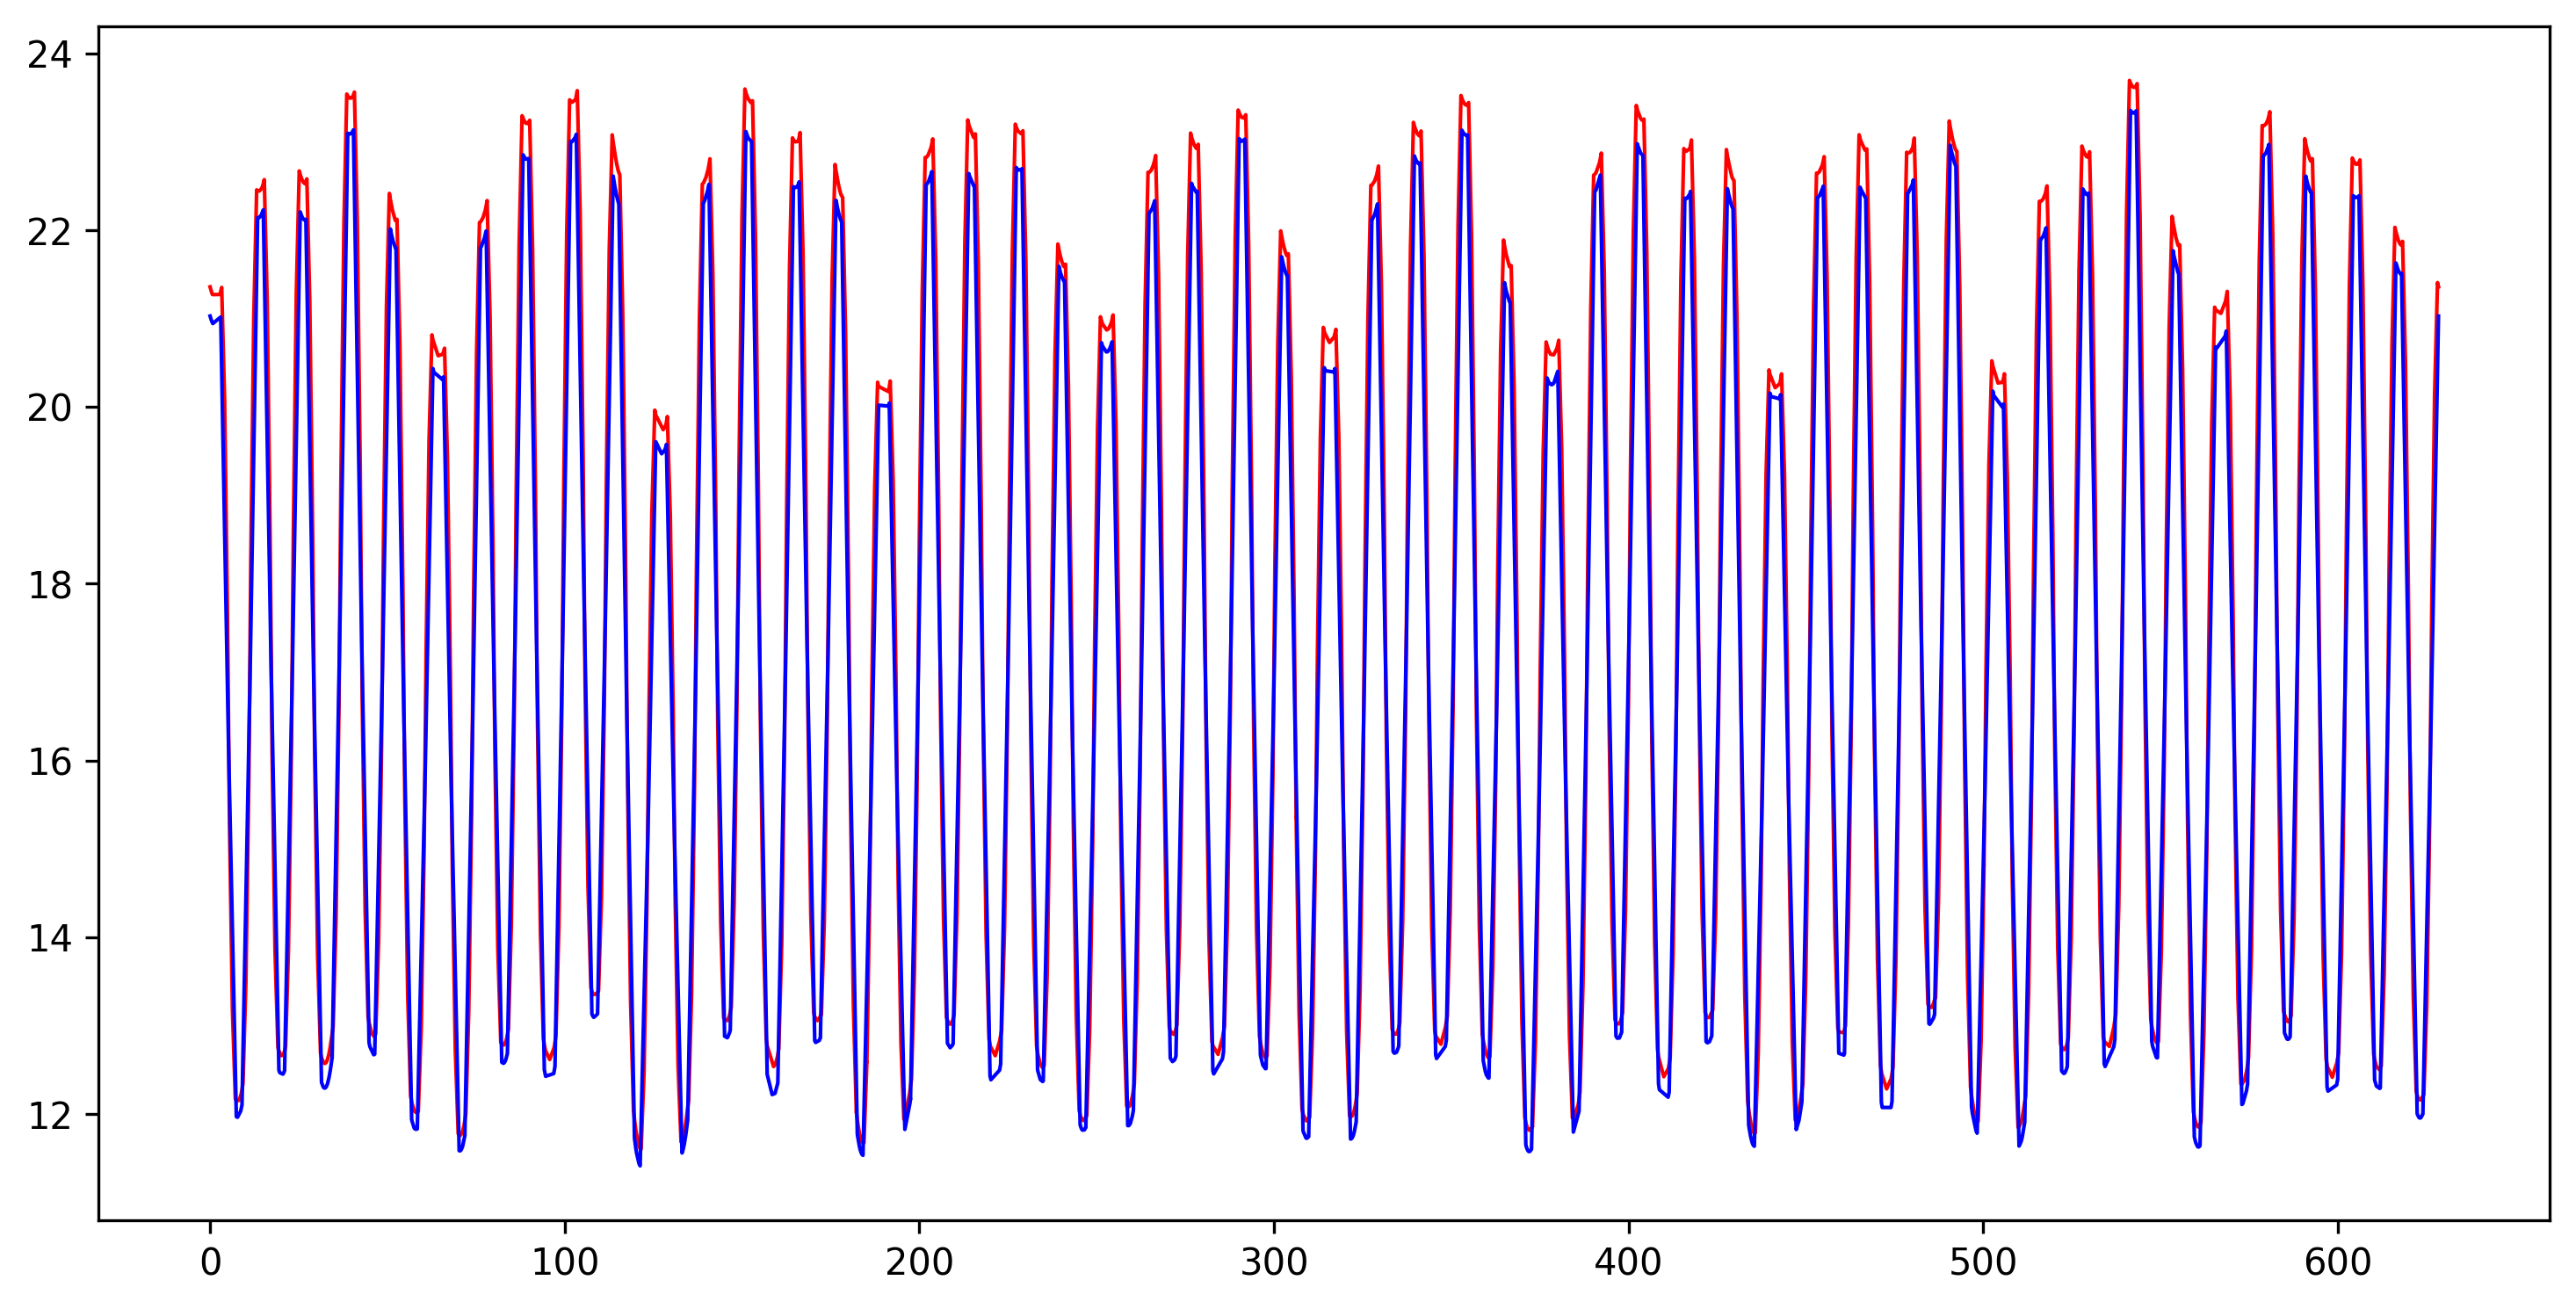

In [9]:
madx.input('''
        match, sequence=PS;
            vary, name= kd_SC, step= 0.00001;
            CONSTRAINT, sequence=PS, RANGE='pr.bwsh68',DX='''+str(2.47270579*1.027)+''';
            JACOBIAN, calls = 50000, tolerance=1.0e-15;
        endmatch;
        ''' )
madx.twiss()

plt.plot(madx.table.twiss.s,madx.table.twiss.betx, 'r-')
plt.plot(madx_og.table.twiss.s,madx_og.table.twiss.betx, 'b-')

madx.eval('kd_SC')



### ex = 1.0 => dQx = -0.23515741915174274
### ex = 1.5 => dQx = -0.1892651330338367
### ex = 2.0 => dQx = -0.15880994561961453

In [3]:
averagebeta = 17.25
dQx = -0.15880994561961453

(dQx*4*np.pi)/averagebeta/100

-0.0011569070341462622

In [7]:
madx = reset_mad(s_operational,s_possible,ssz)
madx_og = reset_mad_og()
madx_og.twiss()


idxH =[idx for idx,name in enumerate(madx_og.table.twiss['name']) if name.startswith('pr.bwsh68')]
print('Dx = ', madx_og.table.twiss['Dx'][idxH])

# procent = 1.005
# madx.input('''
#         match, sequence=PS;
#             vary, name= kd_SC, step= 0.00001;
#             CONSTRAINT, sequence=PS, RANGE='pr.bwsh68',DX='''+str(madx_og.table.twiss['Dx'][idxH][0]*procent)+''';
#             JACOBIAN, calls = 50000, tolerance=1.0e-15;
#         endmatch;
#         ''' )

dQx = -0.15880994561961453
N = 200e10
r0 = 1.54e-18
R = 100
sigma = 2.4e-3
beta = 0.95
gamma = 3.14
averagebeta = 17.10379204657922

#k = (N*r0)/(sigma**2 *beta**2 *gamma**3)
#k = (N*r0*averagebeta)/(beta**2 *emittance *gamma**3)
k = (-dQx*2*np.pi)/averagebeta
print(k/101)

madx.input('kd_SC = -'+str(k/101)+';')
madx.twiss()

print('SC tuneshift :',dQx/2)
print('Original tunes :',madx_og.table.summ.q1[0],madx_og.table.summ.q2[0])
print('New tunes :',madx.table.summ.q1[0],madx.table.summ.q2[0])


print('tune diff:',madx.table.summ.q1[0]-madx_og.table.summ.q1[0])
dQ = madx.table.summ.q1[0]-madx_og.table.summ.q1[0]
print('average beta from dk',-4*np.pi*dQ/k)
temp = np.trapz(madx.table.twiss.betx, x=madx.table.twiss.s)
print('average beta from intergral',temp/(2*np.pi*R))


print('Defocusing',madx.eval('kd_SC'))


dx = []
dxOG = []
c = [0.0,0.4,0.8,1.0,1.2,1.6]
for ee,knob in enumerate(c):
    madx.input('Dx_bwsh68_leq = '+str(knob*0.99)+';')
    madx.twiss()
    madx_og.input('Dx_bwsh68_leq = '+str(knob*0.99)+';')
    madx_og.twiss()
    disp = madx.table.twiss.dx
    pos_WS2 = [i for i,elem in enumerate(madx.table.twiss.name) if elem.startswith('pr.bwsh68')][0]
    dx.append(disp[pos_WS2])

    disp = madx_og.table.twiss.dx
    pos_WS2 = [i for i,elem in enumerate(madx_og.table.twiss.name) if elem.startswith('pr.bwsh68')][0]
    dxOG.append(disp[pos_WS2])

    # plt.figure()
    # plt.title('knob = '+ str(knob))
    # plt.plot(madx.table.twiss.s,madx.table.twiss.dx, 'r-')
    # plt.plot(madx_og.table.twiss.s,madx_og.table.twiss.dx, 'b-')


Dx =  [2.47271441]
0.0005776220772387943
SC tuneshift : -0.07940497280980727
Original tunes : 6.213629028466018 6.238460002740978
New tunes : 6.133075491861341 6.3153184236116955
tune diff: -0.08055353660467723
average beta from dk 17.351192122475464
average beta from intergral 17.249677396564156
Defocusing -0.0005776220772387943


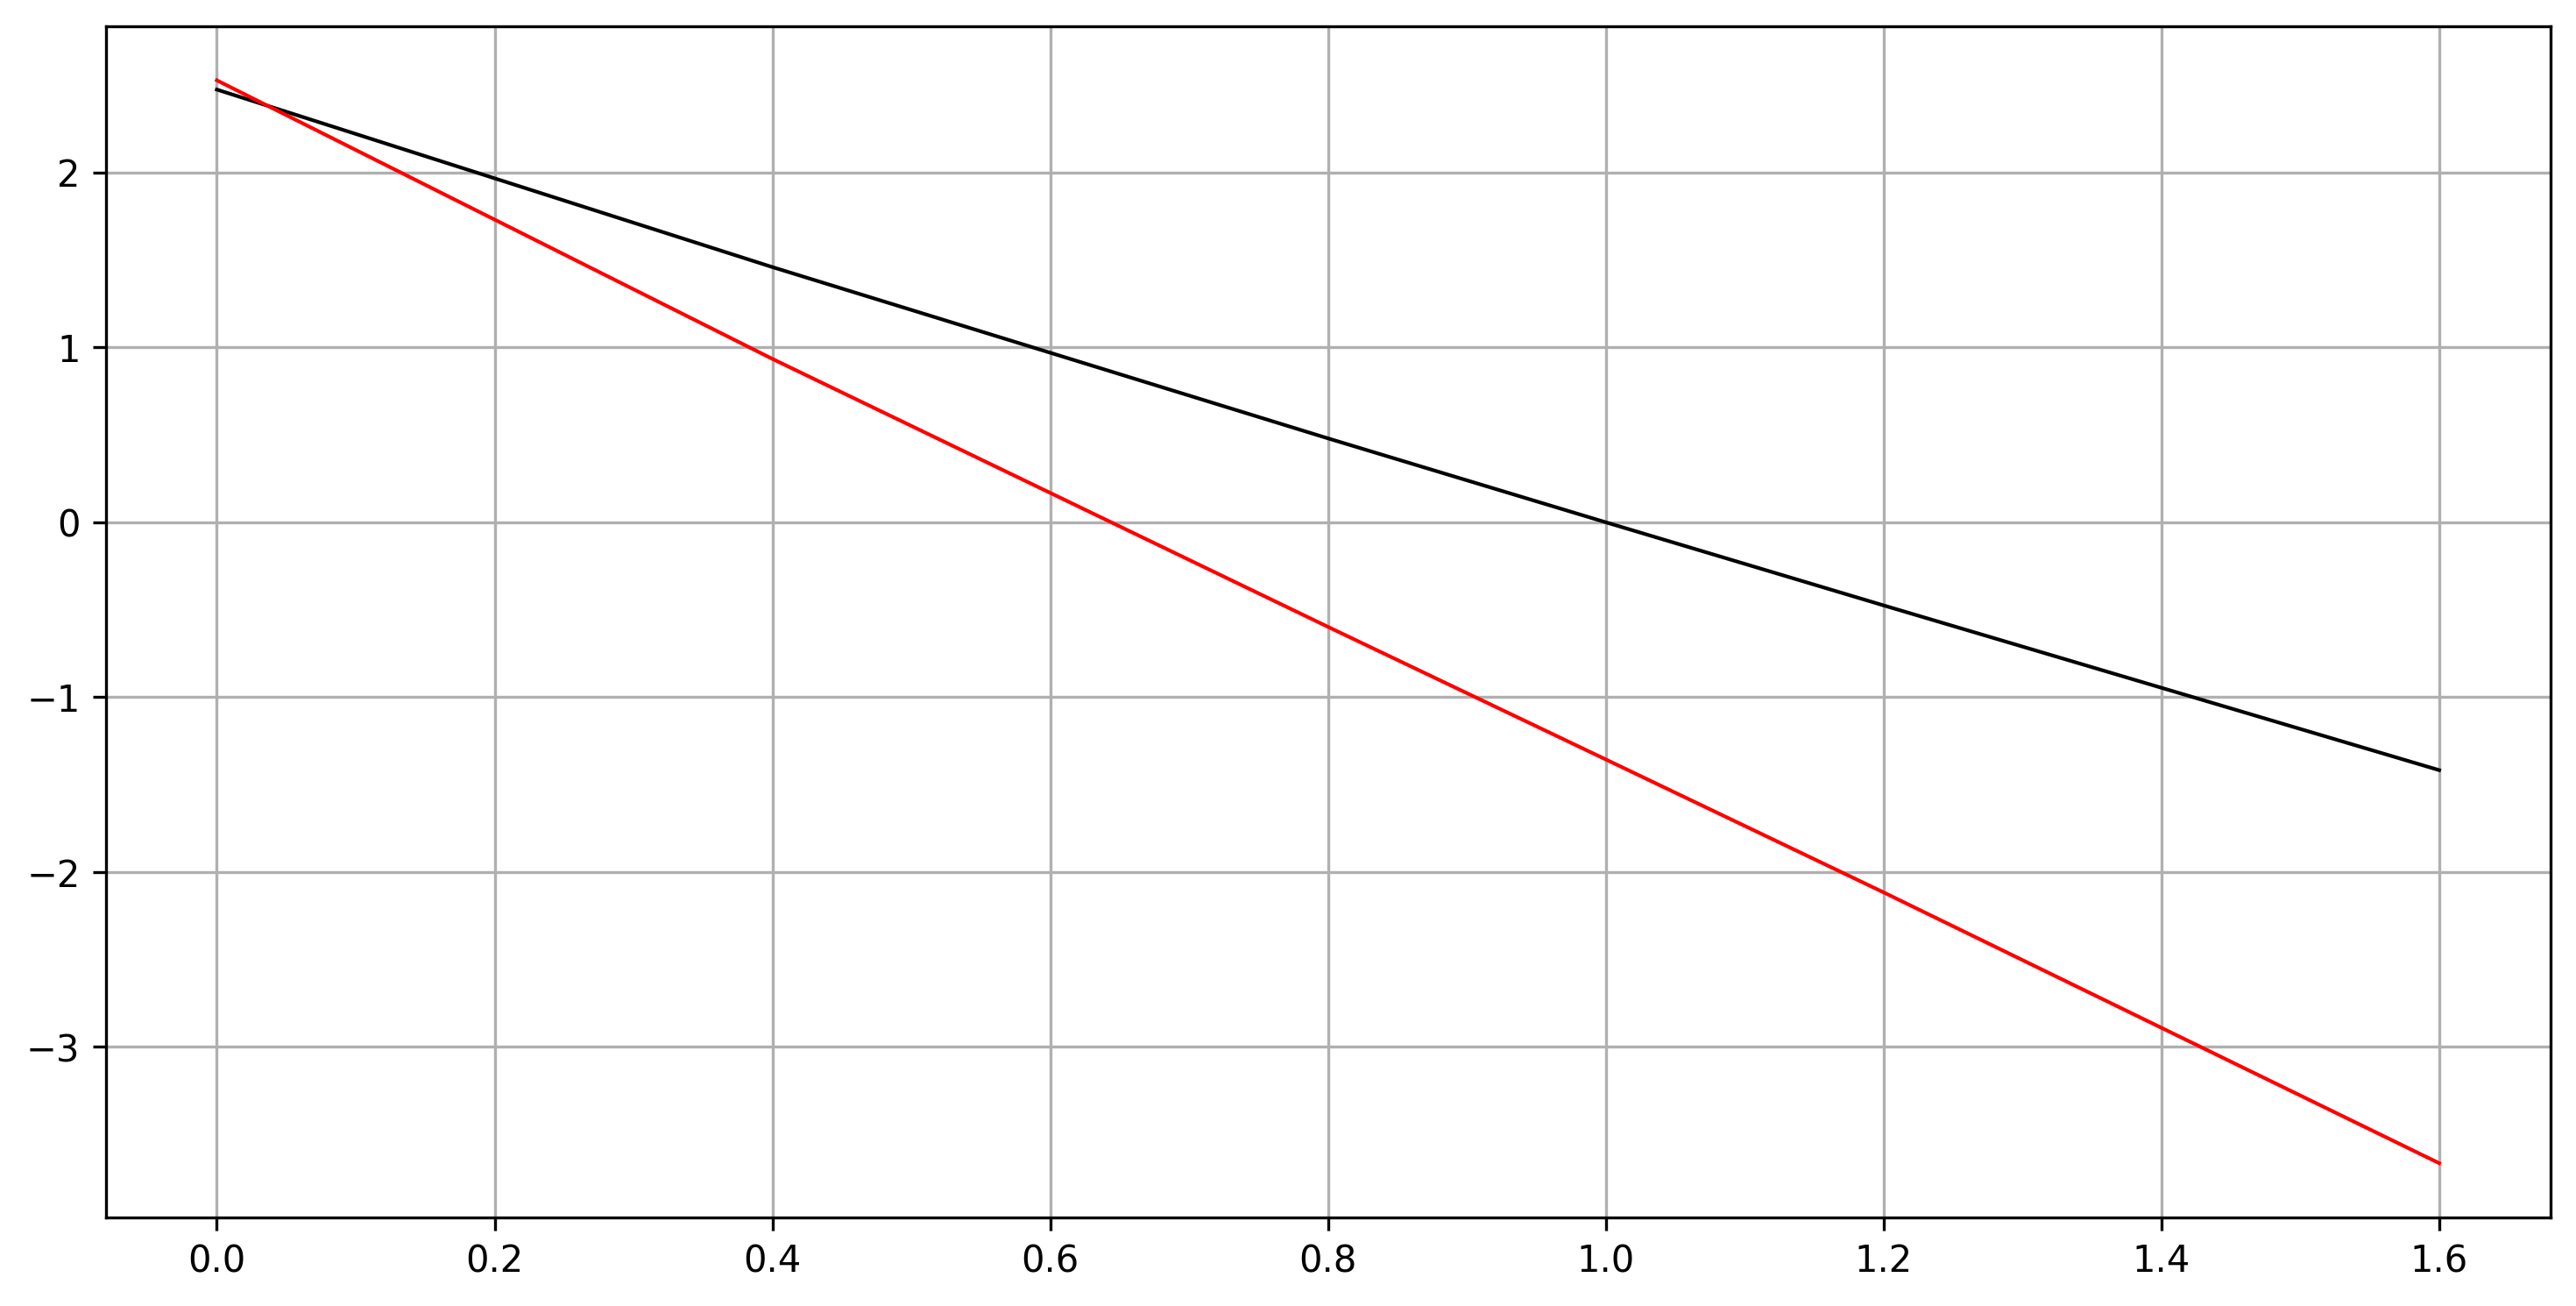

In [8]:

plt.plot(c,dxOG,'k-',label='no SC')
plt.plot(c,dx,'r-')

plt.grid()
# plt.xlim([0.75,1.05])

In [30]:
madx = reset_mad(s_operational,s_possible,ssz)
madx_og = reset_mad_og()
madx_og.twiss()


idxH =[idx for idx,name in enumerate(madx_og.table.twiss['name']) if name.startswith('pr.bwsh68')]
print('Dx = ', madx_og.table.twiss['Dx'][idxH])

# procent = 1.005
# madx.input('''
#         match, sequence=PS;
#             vary, name= kd_SC, step= 0.00001;
#             CONSTRAINT, sequence=PS, RANGE='pr.bwsh68',DX='''+str(madx_og.table.twiss['Dx'][idxH][0]*procent)+''';
#             JACOBIAN, calls = 50000, tolerance=1.0e-15;
#         endmatch;
#         ''' )

N = 200e10
r0 = 1.54e-18
R = 100
sigma = 2.4e-3
beta = 0.95
gamma = 3.14
averagebeta = 17.103792046579226
saveDx = {}

for emittance in [1.0e-4,1.5e-4,2.0e-4]:


    #k = (N*r0)/(sigma**2 *beta**2 *gamma**3)
    k = (N*r0*averagebeta)/(beta**2 *emittance *gamma**3)

    print(k/100)

    madx.input('kd_SC = -'+str(k/100)+';')
    madx.twiss()

    print('Original tunes :',madx_og.table.summ.q1[0],madx_og.table.summ.q2[0])
    print('New tunes :',madx.table.summ.q1[0],madx.table.summ.q2[0])


    print('tune diff:',madx.table.summ.q1[0]-madx_og.table.summ.q1[0])
    dQ = madx.table.summ.q1[0]-madx_og.table.summ.q1[0]
    print('average beta from dk',-4*np.pi*dQ/k)
    temp = np.trapz(madx.table.twiss.betx, x=madx.table.twiss.s)
    print('average beta from intergral',temp/(2*np.pi*R))


    print('Defocusing',madx.eval('kd_SC'))


    dx = []
    dxOG = []
    c = [0.0,0.4,0.8,1.0,1.2,1.6]
    for ee,knob in enumerate(c):
        madx.input('Dx_bwsh68_leq = '+str(knob*0.99)+';')
        madx.twiss()
        madx_og.input('Dx_bwsh68_leq = '+str(knob*0.99)+';')
        madx_og.twiss()
        disp = madx.table.twiss.dx
        pos_WS2 = [i for i,elem in enumerate(madx.table.twiss.name) if elem.startswith('pr.bwsh68')][0]
        dx.append(disp[pos_WS2])

        disp = madx_og.table.twiss.dx
        pos_WS2 = [i for i,elem in enumerate(madx_og.table.twiss.name) if elem.startswith('pr.bwsh68')][0]
        dxOG.append(disp[pos_WS2])

        # plt.figure()
        # plt.title('knob = '+ str(knob))
        # plt.plot(madx.table.twiss.s,madx.table.twiss.dx, 'r-')
        # plt.plot(madx_og.table.twiss.s,madx_og.table.twiss.dx, 'b-')


    saveDx[emittance] = dx

Dx =  [2.47271441]
0.00018854150494250932
Original tunes : 6.213629028466018 6.238460002740978
New tunes : 6.186582619606213 6.262839210736156
tune diff: -0.027046408859805027
average beta from dk 18.02654527571705
average beta from intergral 17.102735791293295
Defocusing -0.00018854150494250932
0.00012569433662833955
Original tunes : 6.229799812061223 6.2170759635459145
New tunes : 6.210948856534017 6.233227118077909
tune diff: -0.018850955527205393
average beta from dk 18.846361733075547
average beta from intergral 17.516336252320137
Defocusing -0.00012569433662833955
9.427075247125466e-05
Original tunes : 6.229799812061223 6.2170759635459145
New tunes : 6.215352384804047 6.228896044158287
tune diff: -0.01444742725717596
average beta from dk 19.258542079954974
average beta from intergral 17.49102342968263
Defocusing -9.427075247125466e-05


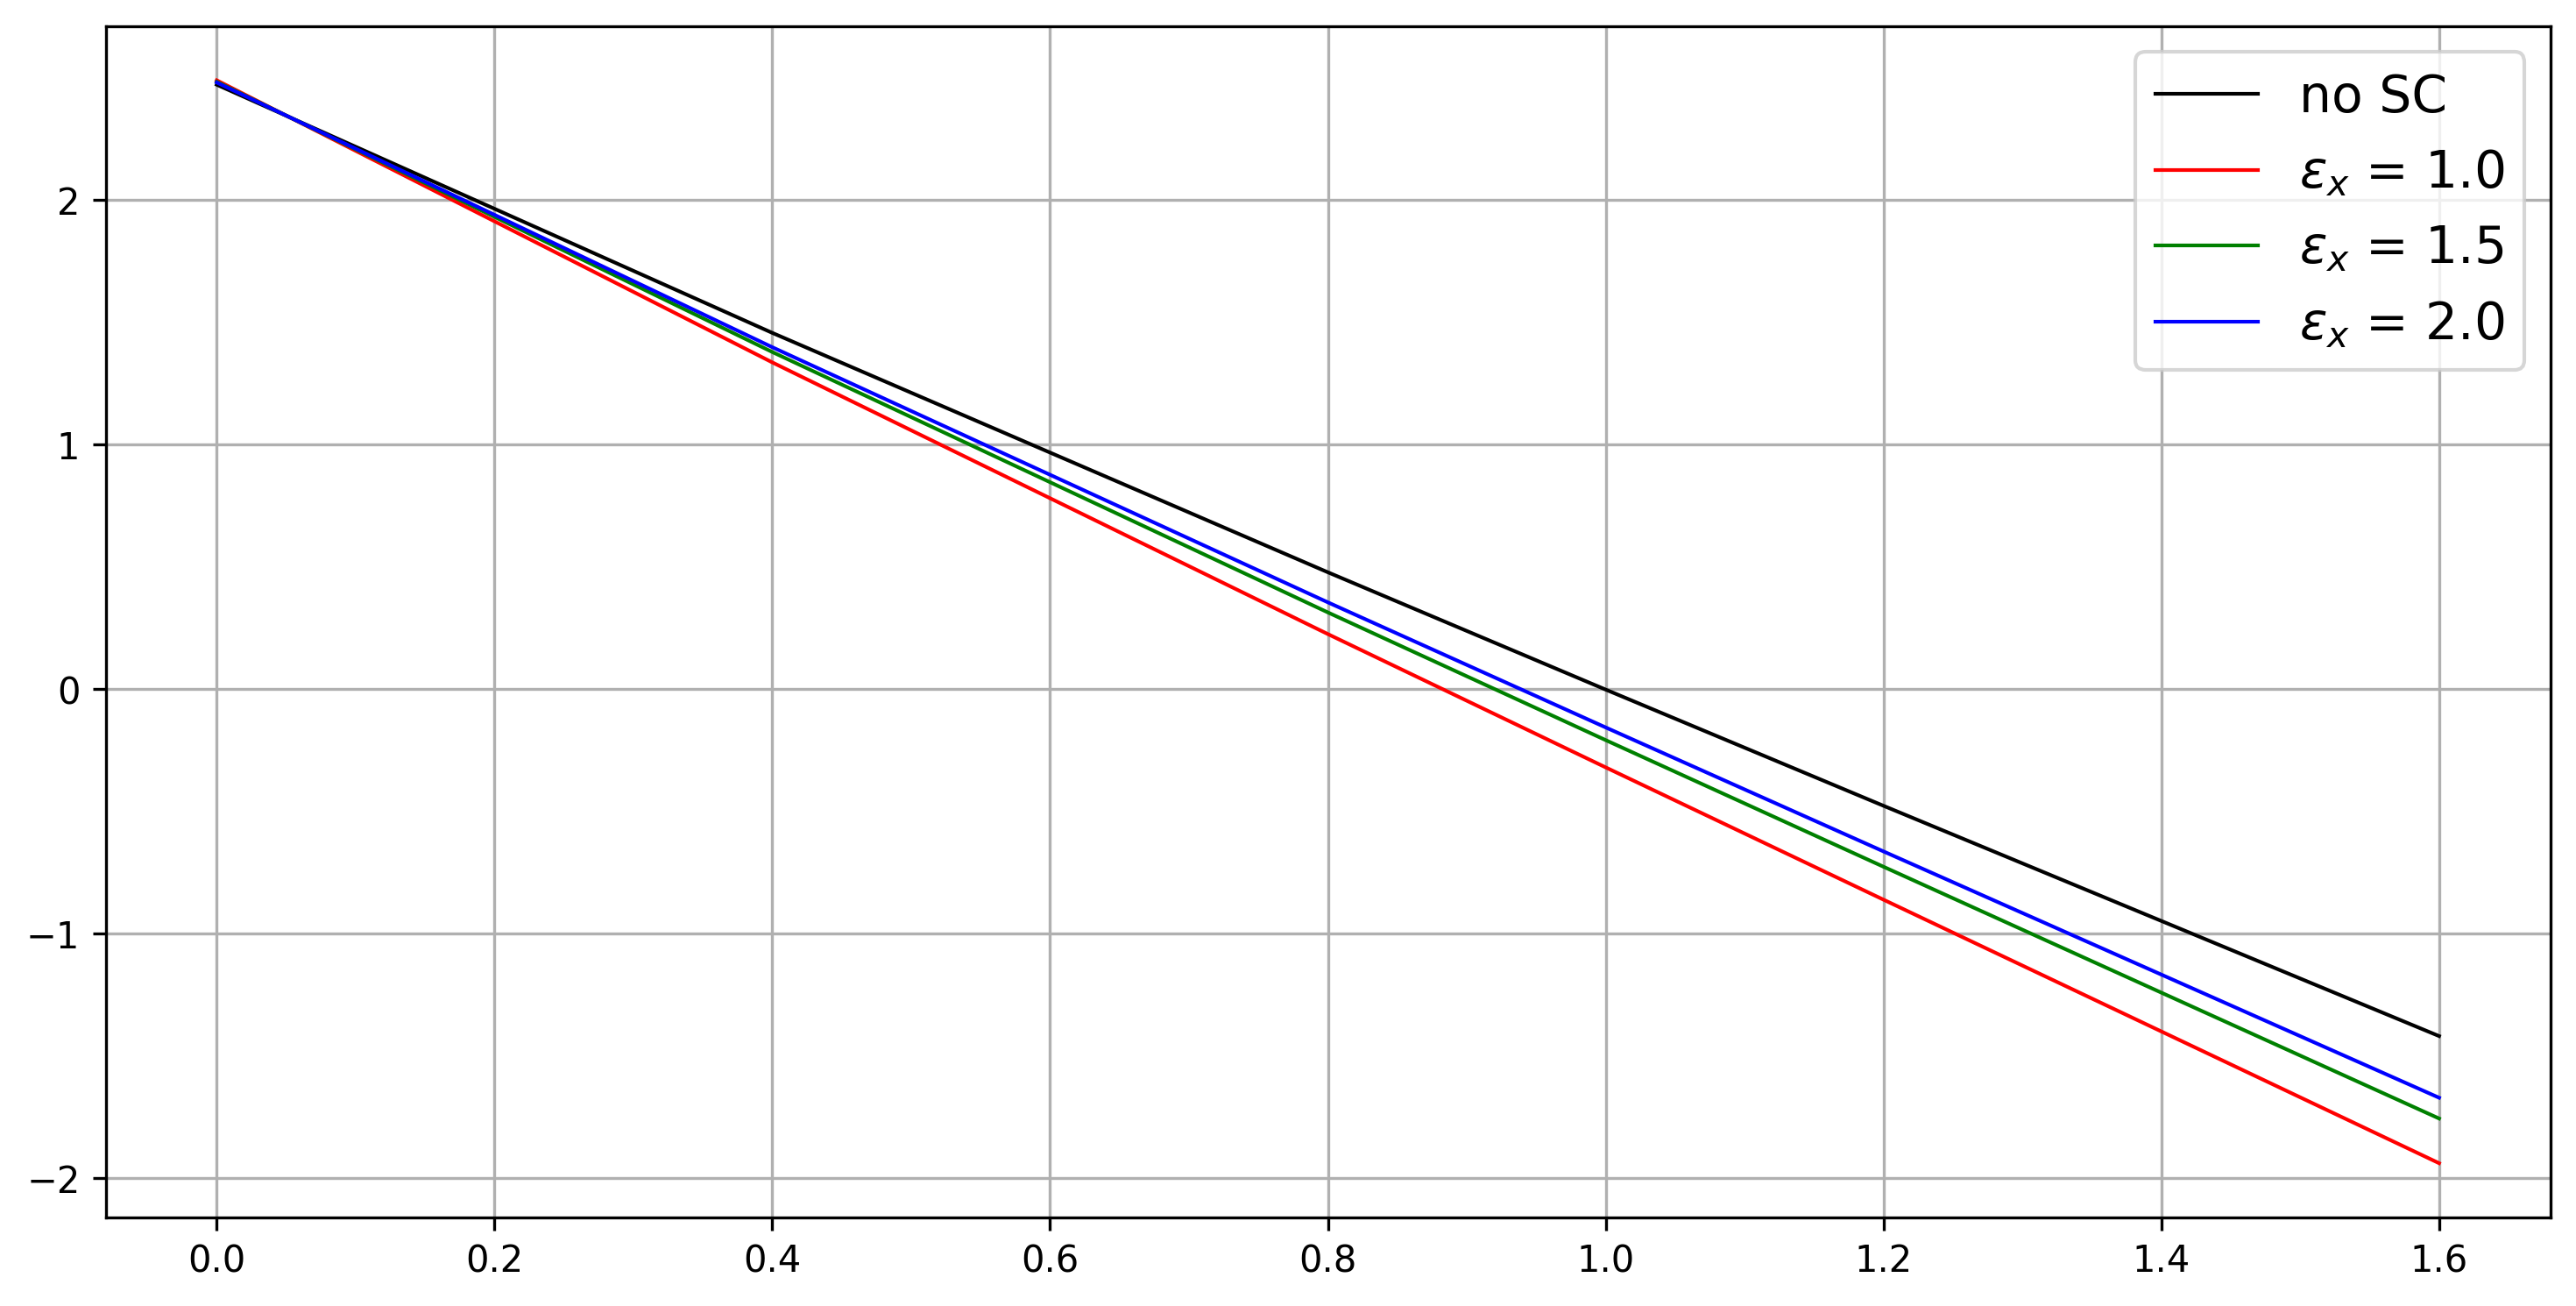

In [35]:
colors = ['r-','g-','b-'] 
plt.plot(c,dxOG,'k-',label='no SC')
for ee,emittance in enumerate([1.0e-4,1.5e-4,2.0e-4]):
    dx = saveDx[emittance]
    plt.plot(c,dx,colors[ee],label=r'$\epsilon_x$ = '+str(np.round(emittance*1e5)/10))

plt.legend()
plt.grid()
# plt.xlim([0.75,1.05])

(0.75, 1.05)

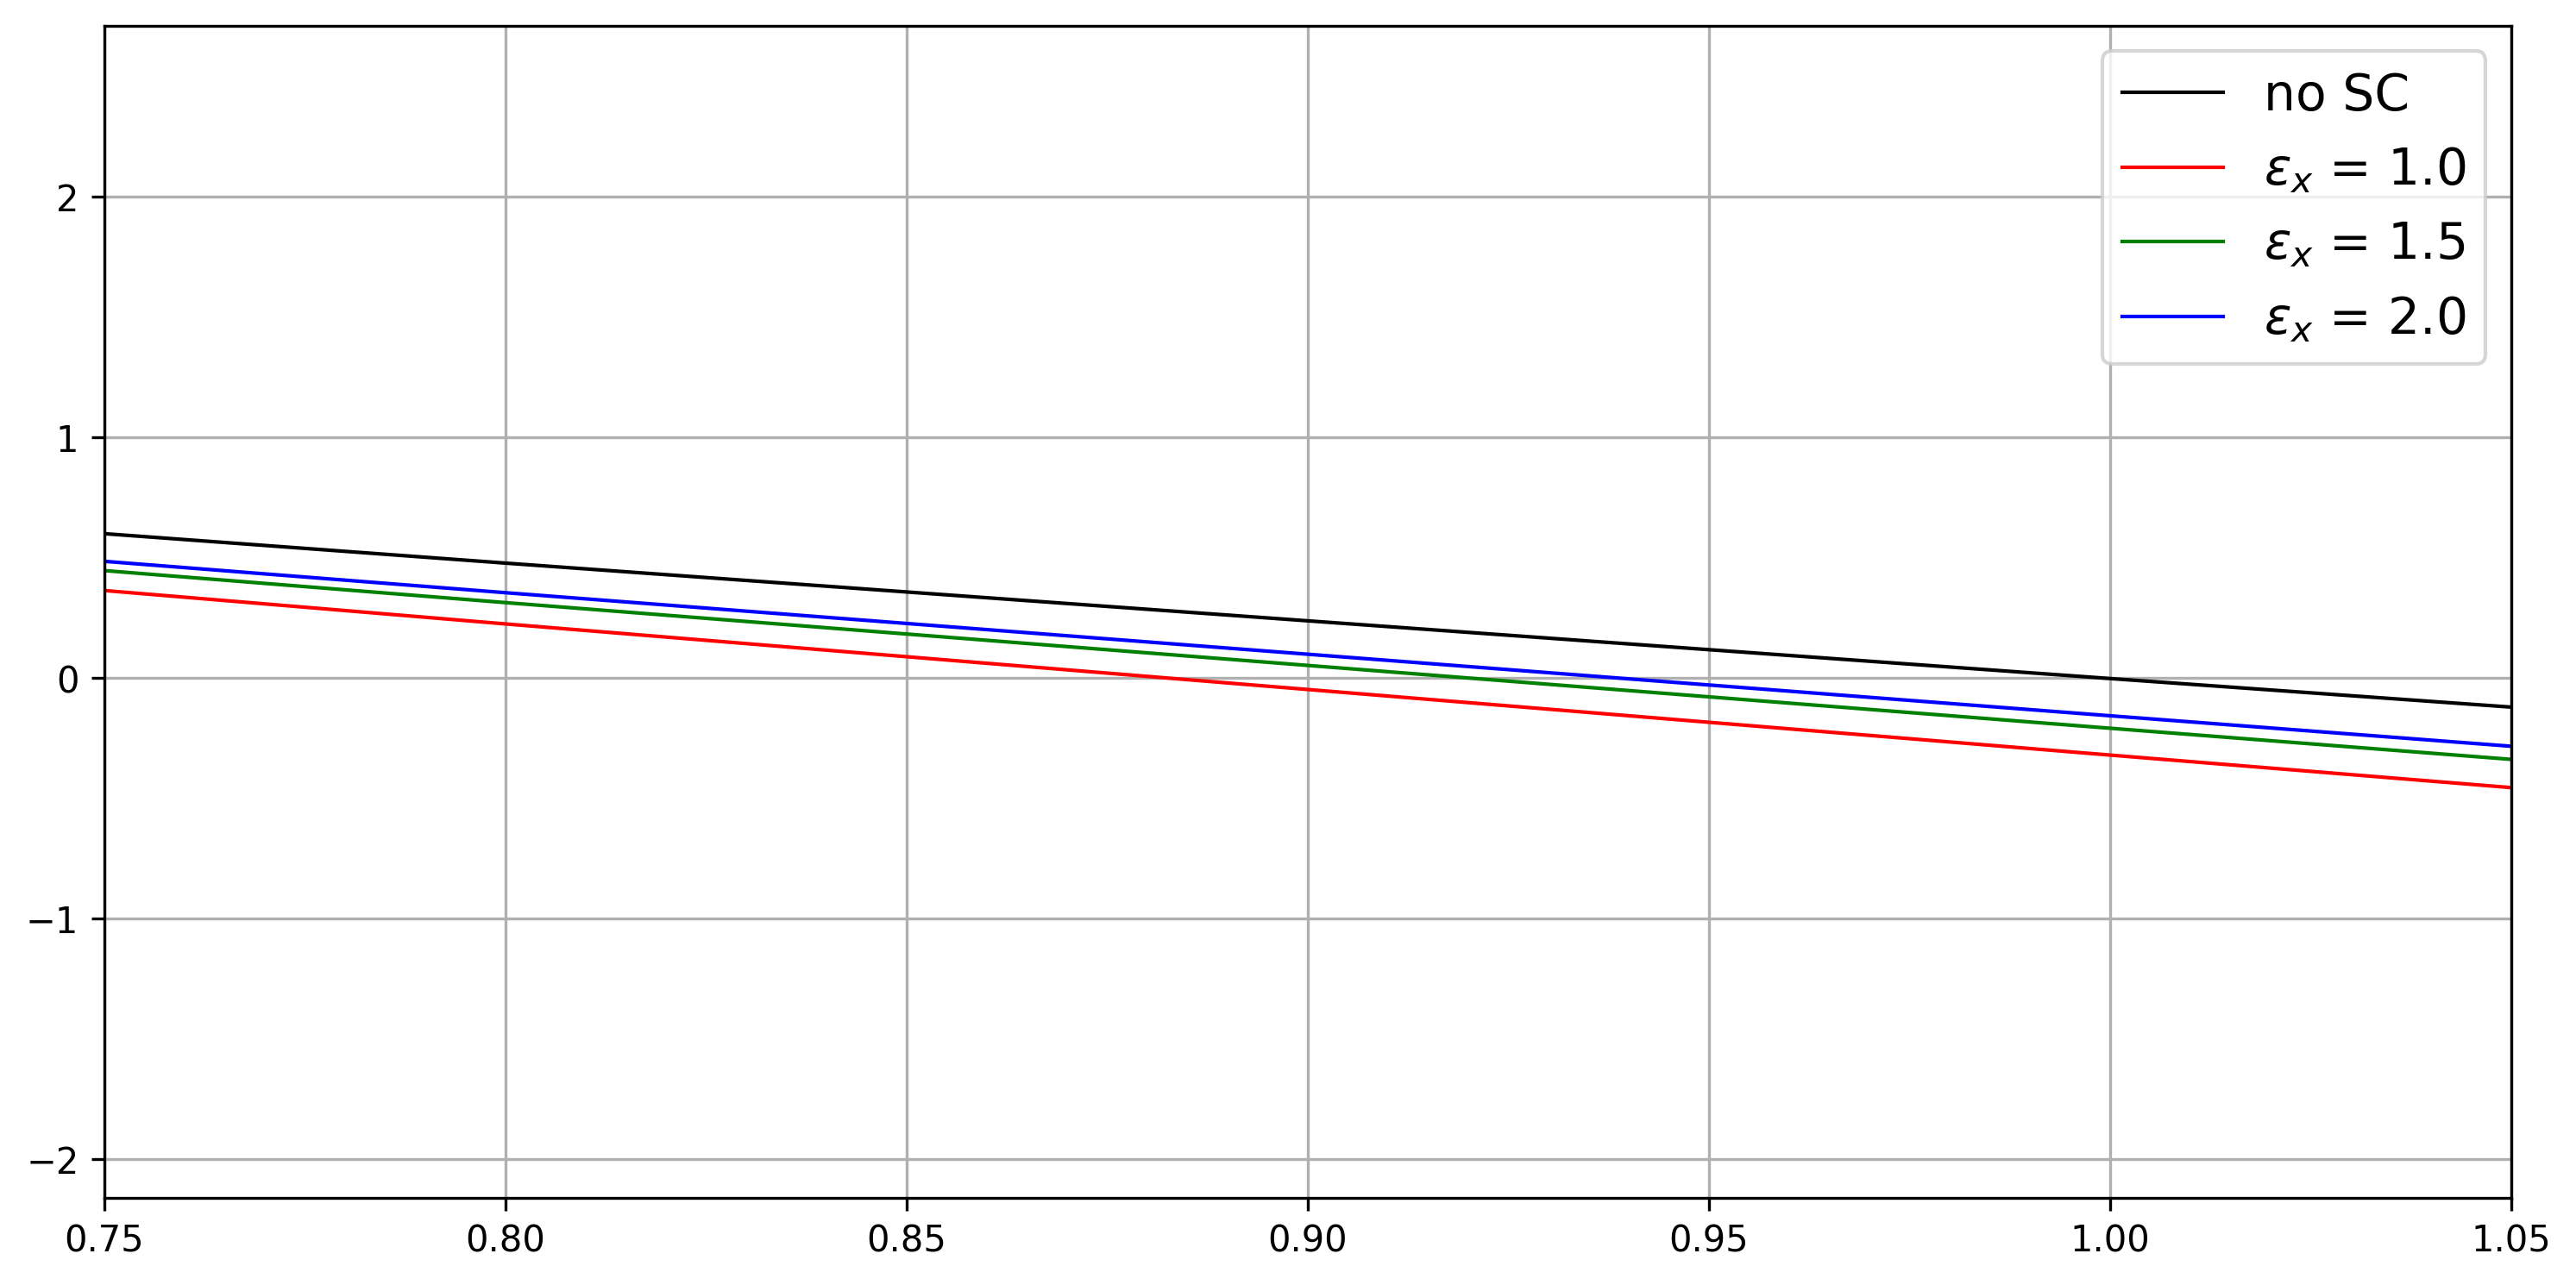

In [36]:
colors = ['r-','g-','b-'] 
plt.plot(c,dxOG,'k-',label='no SC')
for ee,emittance in enumerate([1.0e-4,1.5e-4,2.0e-4]):
    dx = saveDx[emittance]
    plt.plot(c,dx,colors[ee],label=r'$\epsilon_x$ = '+str(np.round(emittance*1e5)/10))

plt.legend()
plt.grid()
plt.xlim([0.75,1.05])

In [ ]:
import numpy as np
N = 200e10
r0 = 1.5e-18
R = 100
sigma = 3.7e-3
beta = 0.95
gamma = 3.14

k = (N*r0)/(R*np.pi*sigma**2 *beta**2 *gamma**3)*R*2*np.pi
k/50

0.00031371959314745434